In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import *
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.losses import mean_squared_error

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
import h5py
import time

In [3]:

appName = "ClimateEventsApp"
master = 'local'

# Create Spark session
spark = SparkSession.builder \
    .master(master) \
    .appName(appName) \
    .getOrCreate()

In [4]:
schema = StructType() \
      .add("Date",DateType(),True) \
      .add("MaxT",FloatType(),True) \
      .add("MinT",FloatType(),True) \
      .add("AvgT",FloatType(),True) \
      .add("MaxWind",FloatType(),True) \
      .add("AvgWind",FloatType(),True) \
      .add("MaxRain",FloatType(),True) \
      .add("MinRain",FloatType(),True) \
      .add("AvgRain",FloatType(),True) \
      .add("MaxHU",FloatType(),True) \
      .add("MinHU",FloatType(),True) \
      .add("AvgHU",FloatType(),True) \
      .add("ExtremeDay",FloatType(),True) 



In [5]:
df = spark.read.format("csv") \
      .option("header", True) \
      .option("delimiter", "|") \
      .schema(schema) \
      .load("./DFCLEAN_Eng.csv") 

In [6]:
print(df.count()/365)
df = df.withColumn("Year",F.year("Date")).withColumn("Month",F.month("Date")).orderBy("Date")

36.53972602739726


# LSTM 

Training and test data are obtained from the spark dataframes, 2021 being the test data.

In [7]:
# max T and Max Rain are the variable on which we are going to use
# the first 6 month of 2021 will be used as test set, all the rest as training data

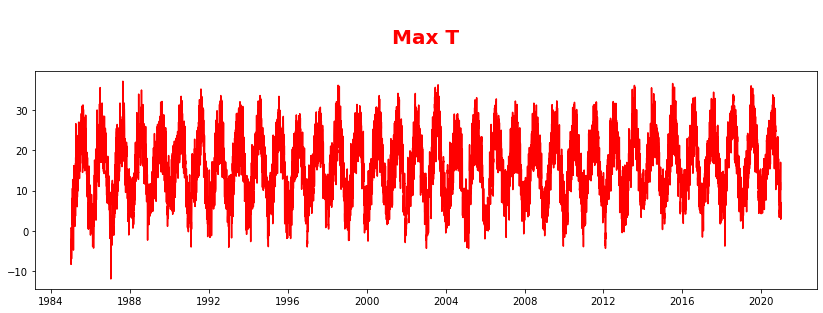

In [8]:
data = df.select("Date","MaxT","MaxRain","Year").filter(df.Year != 2021).collect()
day = [i.Date for i in data]
MaxT_training_data = [i.MaxT for i in data]
MaxRain_training_data = [i.MaxRain for i in data]

plt.figure(figsize=(14,4))
plt.plot(day, MaxT_training_data, color = 'red')
plt.title('\nMax T\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

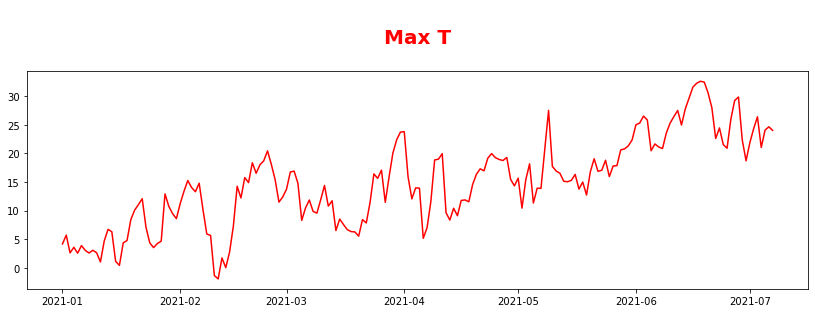

In [9]:
#test data
data = df.select("Date","MaxT","MaxRain","Year").filter(df.Year == 2021).collect()
day = [i.Date for i in data]
MaxT_test_data = [i.MaxT for i in data]
MaxT_test_data_all = [i.MaxT for i in data]

MaxRain_test_data = [i.MaxRain for i in data]

plt.figure(figsize=(14,4))
plt.plot(day, MaxT_test_data, color = 'red')
plt.title('\nMax T\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

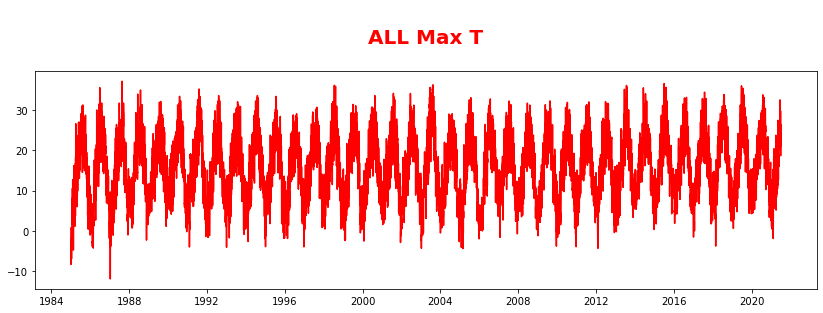

In [10]:
#test data
data = df.select("Date","MaxT","MaxRain","Year").collect()
day = [i.Date for i in data]
all_data_T = [i.MaxT for i in data]
all_data_Rain = [i.MaxRain for i in data]

plt.figure(figsize=(14,4))
plt.plot(day, all_data_T, color = 'red')
plt.title('\nALL Max T\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

In [11]:
batch_size = 64

Test and training data have to be multiple of the batch size

In [12]:
MaxT_test_data_CUT = MaxT_test_data
while True:
    if len(MaxT_test_data_CUT)%batch_size == 0:
        break
    else:
        MaxT_test_data_CUT = MaxT_test_data_CUT[:-1]

In [13]:
MaxT_training_data_CUT = MaxT_training_data

while True:
    if len(MaxT_training_data_CUT)%batch_size == 0:
        break
    else:
        MaxT_training_data_CUT = MaxT_training_data_CUT[1:]

In [14]:

length  = (len(MaxT_training_data_CUT))

In [15]:
# Set time steps to 7 days
timesteps= 3
# Adding timesteps * 2
upper_train = length + timesteps*2


In [16]:

MaxT_training_data_enlarged = MaxT_training_data_CUT + MaxT_test_data_CUT[:upper_train-length]


In [17]:
MaxT_training_data_enlarged = np.array(MaxT_training_data_enlarged)
MaxT_training_data_enlarged_reshaped = np.reshape(MaxT_training_data_enlarged, (MaxT_training_data_enlarged.shape[0],1))


In [18]:
#scale between 0 and 1. the weights are esier to find.
sc = MinMaxScaler(feature_range = (0, 1))
MaxT_training_data_enlarged_reshaped_scaled = sc.fit_transform(np.float64(MaxT_training_data_enlarged_reshaped))


In [19]:


# Empty Lists to store X_train and y_train
MaxT_training_data_X_matrix = []
MaxT_training_data_Y_matrix = []
# Creating a data structure with n timesteps
for i in range(timesteps, length + timesteps):
    #create X_train matrix
    #24*7 items per array (timestep) 
    MaxT_training_data_X_matrix.append(MaxT_training_data_enlarged_reshaped_scaled[i-timesteps:i,0])
    #create Y_train matrix
    #24*7 items per array (timestep)
    MaxT_training_data_Y_matrix.append(MaxT_training_data_enlarged_reshaped_scaled[i+1,0])
    

In [20]:
MaxT_training_data_X_matrix = np.array(MaxT_training_data_X_matrix) 
MaxT_training_data_Y_matrix = np.array(MaxT_training_data_Y_matrix) 
print(MaxT_training_data_X_matrix.shape)



# reshape arrays
MaxT_training_data_X_matrix = np.reshape(MaxT_training_data_X_matrix, 
                                         (MaxT_training_data_X_matrix.shape[0], 
                                          MaxT_training_data_X_matrix.shape[1], 1))
MaxT_training_data_Y_matrix = np.reshape(MaxT_training_data_Y_matrix, 
                                         (MaxT_training_data_Y_matrix.shape[0], 
                                         1, 1))


(13120, 3)


The model has been trained ones, then the cell has been disabled for convenience.

In [21]:
regressor = load_model('./model_trained-1.h5')